In [13]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [14]:
## USE: full log(returns)/returns dataframe
## Risk Adjusted Returns

df = pd.read_pickle("../Data/risk_adj_returns.pkl").iloc[1:]

drop_columns = []
for col in df.columns:
    if df[col].isnull().all() == True:
        drop_columns.append(col)
        
df.drop(columns=drop_columns, inplace=True)

# df['pct_change'] = df.close.pct_change()
# df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
# df = df.dropna()

In [15]:
#df = df.dropna(how='any',axis=0) #All rows have NaN

In [16]:
df.tail()

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2021-05-24,NaN,NaN,NaN,NaN,-0.073424,NaN,-0.026594,NaN,NaN,NaN,...,-0.042002,0.042352,-0.007893,-0.034946,-0.006981,0.025437,0.006211,-0.034570,0.045914,-0.023507
2021-05-25,NaN,NaN,NaN,NaN,-0.041516,NaN,-0.023492,NaN,NaN,NaN,...,-0.045774,-0.040381,-0.029872,-0.042776,-0.034353,-0.047507,-0.041449,-0.032225,-0.001858,-0.073776
2021-05-26,NaN,NaN,NaN,NaN,-0.133718,NaN,-0.022297,NaN,NaN,NaN,...,-0.018214,0.006846,-0.041720,0.014670,0.006996,0.050378,-0.030298,0.008515,-0.039008,-0.103963
2021-05-27,NaN,NaN,NaN,NaN,-0.114582,NaN,-0.030586,NaN,NaN,NaN,...,-0.050278,-0.001888,-0.039754,-0.029330,-0.021043,-0.042413,-0.000474,-0.003118,-0.012079,0.010919
2021-05-28,NaN,NaN,NaN,NaN,-0.046110,NaN,0.001882,NaN,NaN,NaN,...,-0.059837,-0.051037,-0.046412,-0.017292,-0.040496,-0.066158,-0.032654,-0.031242,-0.039250,-0.007592


In [17]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [18]:
df = get_investable(pd.to_datetime('2018-05-11'), 200)
df

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2018-05-11,-0.033261,-0.056147,-0.056673,-0.039225,-0.078155,-0.079176,-0.055281,-0.036198,-0.062879,-0.060282,...,-0.030098,-0.058198,-0.028429,-0.050278,-0.080133,-0.024472,-0.052140,-0.019944,-7.289672e-02,-0.031952
2018-05-10,-0.001857,-0.007957,-0.056608,-0.033577,-0.012766,-0.038382,-0.031704,-0.042638,-0.012963,-0.051148,...,-0.056529,-0.045813,-0.015254,0.108949,-0.000408,-0.018463,-0.030641,-0.039673,7.790037e-03,-0.075911
2018-05-09,-0.032497,0.014964,-0.041537,-0.019209,0.009759,-0.152829,-0.034908,-0.049782,-0.029491,-0.085189,...,0.030915,-0.006775,-0.098720,0.026074,-0.007489,-0.041385,-0.049166,-0.000544,-3.590120e-02,-0.052591
2018-05-08,-0.119326,-0.029451,-0.070543,-0.015943,0.022881,-0.186745,-0.023214,-0.047493,-0.034577,-0.046590,...,-0.051192,-0.039952,-0.071749,-0.048822,-0.039231,0.017063,-0.038039,-0.024803,-2.449209e-02,-0.070835
2018-05-07,-0.039900,0.012059,-0.056630,-0.000645,-0.030319,-0.127271,-0.049799,-0.023339,-0.029050,-0.079179,...,-0.046167,0.016789,0.003434,0.055430,-0.044564,-0.025124,-0.087165,0.004368,-4.533198e-02,-0.074954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-02,-0.072393,-0.072199,-0.091406,-0.072376,-0.001441,-0.069006,-0.054409,-0.027164,0.062017,-0.128361,...,-0.066717,-0.000397,-0.034413,-0.047709,-0.072616,-0.041856,-0.050222,-0.016288,-8.383439e-03,-0.039350
2017-08-01,-0.081210,-0.020391,0.099262,-0.018858,-0.136634,-0.083397,-0.056063,-0.039072,-0.025318,0.021731,...,-0.054461,-0.056564,-0.034920,0.007488,-0.025096,-0.018787,-0.029751,0.011307,-3.998029e-02,-0.038914
2017-07-31,-0.112960,-0.071512,-0.105417,-0.066444,-0.069153,-0.081507,-0.042095,-0.034474,-0.057237,-0.034575,...,-0.058288,-0.096375,-0.038522,-0.056268,-0.050467,-0.035428,-0.043417,-0.056971,2.785112e-17,-0.038776


In [19]:
tts = train_test_split(df, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [20]:
train.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2017-09-28,0.033774,-0.032232,-0.071387,-0.084644,-0.076437,-0.076465,-0.035913,-0.049128,-0.059533,-0.089435,...,-0.053948,-0.042377,-0.044853,0.024979,-0.039263,-0.017803,-0.042860,-0.043971,-0.016182,-0.061822
2017-09-27,-0.130996,0.005307,-0.063771,-0.039784,-0.017728,-0.143054,-0.030959,-0.014198,-0.029317,-0.102140,...,-0.050615,-0.057166,-0.010357,0.044859,0.029447,-0.029128,-0.038377,-0.028755,0.010398,-0.014246
2017-09-26,-0.060831,-0.052681,-0.084904,-0.036838,-0.040810,-0.079077,-0.041050,-0.057685,-0.006364,-0.070131,...,-0.062638,-0.033960,-0.045905,-0.014777,-0.020430,-0.003253,-0.046713,-0.067935,-0.022240,-0.070503
2017-09-25,-0.071303,-0.115842,-0.041493,-0.057992,0.042759,-0.058970,-0.062454,-0.030108,-0.065593,-0.051800,...,-0.045482,-0.065947,-0.069041,-0.064799,-0.071611,-0.040592,-0.050160,-0.048418,-0.053214,-0.049827
2017-09-22,0.003938,-0.045452,-0.090654,-0.104774,-0.000160,-0.142855,-0.057031,-0.033048,-0.067770,-0.059431,...,-0.060346,-0.109388,-0.023386,-0.023368,-0.035876,-0.042236,-0.047319,-0.029264,-0.056097,-0.055420


In [21]:
test.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2017-08-02,-0.072393,-0.072199,-0.091406,-0.072376,-0.001441,-0.069006,-0.054409,-0.027164,0.062017,-0.128361,...,-0.066717,-0.000397,-0.034413,-0.047709,-0.072616,-0.041856,-0.050222,-0.016288,-8.383439e-03,-0.039350
2017-08-01,-0.081210,-0.020391,0.099262,-0.018858,-0.136634,-0.083397,-0.056063,-0.039072,-0.025318,0.021731,...,-0.054461,-0.056564,-0.034920,0.007488,-0.025096,-0.018787,-0.029751,0.011307,-3.998029e-02,-0.038914
2017-07-31,-0.112960,-0.071512,-0.105417,-0.066444,-0.069153,-0.081507,-0.042095,-0.034474,-0.057237,-0.034575,...,-0.058288,-0.096375,-0.038522,-0.056268,-0.050467,-0.035428,-0.043417,-0.056971,2.785112e-17,-0.038776
2017-07-28,-0.118123,-0.051635,-0.075864,-0.067341,-0.003632,-0.103423,-0.024447,-0.036920,-0.061538,-0.066325,...,-0.081006,-0.032072,-0.057375,-0.008117,-0.085291,-0.091201,-0.048182,-0.059747,-5.193123e-02,-0.086363
2017-07-27,-0.101479,-0.102112,-0.078104,-0.096516,-0.022157,-0.010757,-0.104324,-0.040602,-0.088521,-0.060760,...,-0.047624,-0.083475,-0.066640,-0.092776,-0.089591,-0.087135,-0.037175,-0.049250,-7.456348e-02,-0.088761


In [22]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)
pd.DataFrame(training_set_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,0.661406,0.441272,0.526470,0.828958,0.460741,0.520905,0.428907,0.635693,0.393566,0.529545,...,0.343729,0.461508,0.571224,0.259734,0.385493,0.413940,0.525361,0.613774,0.145999,0.745686
1,0.749938,0.551324,0.526684,0.837788,0.648450,0.707915,0.492168,0.598313,0.634965,0.560486,...,0.270439,0.505696,0.629955,0.714857,0.675644,0.429399,0.575786,0.548986,0.374450,0.664123
2,0.663560,0.603668,0.576641,0.860254,0.713111,0.183266,0.483571,0.556848,0.555032,0.445173,...,0.512915,0.644981,0.257864,0.477973,0.649873,0.370430,0.532337,0.677480,0.250746,0.707392
3,0.418774,0.502238,0.480496,0.865360,0.750778,0.027789,0.514947,0.570130,0.530440,0.575925,...,0.285238,0.526607,0.378104,0.263895,0.534352,0.520791,0.558434,0.597818,0.283049,0.673541
4,0.642690,0.597032,0.526614,0.889280,0.598061,0.300429,0.443615,0.710329,0.557165,0.465532,...,0.299173,0.729053,0.713267,0.561883,0.514943,0.412264,0.443215,0.693610,0.224044,0.665899


## Simple multi-layer percepetron (MLP) autoencoder

In [23]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# Can be normalized with a MinMaxScaler to the range [0,1]??

window_length = training_set_scaled.shape[1]
encoding_dim = 3
epochs = 500

# compress the input to a 3-dimensional latent space. 

# input placeholder
input_window = Input(shape=(window_length,))
# encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
# lossy reconstruction of the input
decoded = Dense(window_length, activation='linear')(encoded) #linear

# model mapping an input to its reconstruction
autoencoder = Model(input_window, decoded)

# model mapping an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='MeanSquaredError') #MSE
history = autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = autoencoder.predict(test_set_scaled)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 650)]             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1953      
_________________________________________________________________
dense_1 (Dense)              (None, 650)               2600      
Total params: 4,553
Trainable params: 4,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 10s 10s/step - loss: 0.3038 - val_loss: 0.3284
Epoch 2/500
1/1 [==============================] - 0s 37ms/step - loss: 0.2989 - val_loss: 0.3252
Epoch 3/500
1/1 [==============================] - 0s 62ms/step - loss: 0.2955 - val_loss: 0.3225
Epoch 4/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2927 - val_loss: 0.31

1/1 [==============================] - 0s 30ms/step - loss: 0.0958 - val_loss: 0.1243
Epoch 77/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0943 - val_loss: 0.1229
Epoch 78/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0928 - val_loss: 0.1215
Epoch 79/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0914 - val_loss: 0.1202
Epoch 80/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0899 - val_loss: 0.1189
Epoch 81/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0885 - val_loss: 0.1176
Epoch 82/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0872 - val_loss: 0.1163
Epoch 83/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0858 - val_loss: 0.1151
Epoch 84/500
1/1 [==============================] - 0s 38ms/step - loss: 0.0845 - val_loss: 0.1139
Epoch 85/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0832 - val_loss: 0.1127
Epoch 86/500
1/1 [=====

1/1 [==============================] - 0s 38ms/step - loss: 0.0324 - val_loss: 0.0714
Epoch 159/500
1/1 [==============================] - 0s 38ms/step - loss: 0.0321 - val_loss: 0.0712
Epoch 160/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0317 - val_loss: 0.0710
Epoch 161/500
1/1 [==============================] - 0s 44ms/step - loss: 0.0314 - val_loss: 0.0708
Epoch 162/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0312 - val_loss: 0.0707
Epoch 163/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0309 - val_loss: 0.0705
Epoch 164/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0306 - val_loss: 0.0703
Epoch 165/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0303 - val_loss: 0.0701
Epoch 166/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0300 - val_loss: 0.0700
Epoch 167/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0297 - val_loss: 0.0698
Epoch 168/500


Epoch 240/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0190 - val_loss: 0.0648
Epoch 241/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0190 - val_loss: 0.0648
Epoch 242/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0189 - val_loss: 0.0649
Epoch 243/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0189 - val_loss: 0.0649
Epoch 244/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0188 - val_loss: 0.0649
Epoch 245/500
1/1 [==============================] - 0s 38ms/step - loss: 0.0187 - val_loss: 0.0649
Epoch 246/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0187 - val_loss: 0.0649
Epoch 247/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0186 - val_loss: 0.0649
Epoch 248/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0186 - val_loss: 0.0649
Epoch 249/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0185 - val_loss: 0.0649


Epoch 322/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0163 - val_loss: 0.0664
Epoch 323/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0163 - val_loss: 0.0664
Epoch 324/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0163 - val_loss: 0.0664
Epoch 325/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0163 - val_loss: 0.0664
Epoch 326/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0163 - val_loss: 0.0665
Epoch 327/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0163 - val_loss: 0.0665
Epoch 328/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0162 - val_loss: 0.0665
Epoch 329/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0162 - val_loss: 0.0665
Epoch 330/500
1/1 [==============================] - 0s 43ms/step - loss: 0.0162 - val_loss: 0.0665
Epoch 331/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0162 - val_loss: 0.0666


Epoch 404/500
1/1 [==============================] - 0s 37ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 405/500
1/1 [==============================] - 0s 40ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 406/500
1/1 [==============================] - 0s 43ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 407/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 408/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 409/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 410/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0154 - val_loss: 0.0677
Epoch 411/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0154 - val_loss: 0.0678
Epoch 412/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0154 - val_loss: 0.0678
Epoch 413/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0154 - val_loss: 0.0678


Epoch 486/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0150 - val_loss: 0.0686
Epoch 487/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0150 - val_loss: 0.0686
Epoch 488/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0150 - val_loss: 0.0686
Epoch 489/500
1/1 [==============================] - 0s 37ms/step - loss: 0.0149 - val_loss: 0.0686
Epoch 490/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0149 - val_loss: 0.0686
Epoch 491/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0149 - val_loss: 0.0687
Epoch 492/500
1/1 [==============================] - 0s 43ms/step - loss: 0.0149 - val_loss: 0.0687
Epoch 493/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0149 - val_loss: 0.0687
Epoch 494/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0149 - val_loss: 0.0687
Epoch 495/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0149 - val_loss: 0.0687


In [24]:
pd.DataFrame(encoder.predict(test_set_scaled))

,0,1,2
0,-0.973396,-0.994917,0.954638
1,-0.973760,-0.995692,0.974987
2,-0.946491,-0.989434,0.991947
3,-0.966054,-0.997201,0.991587
4,-0.988301,-0.994133,0.969510
5,-0.985771,-0.994370,0.933277
6,-0.969154,-0.995851,0.922576
7,-0.978213,-0.995519,0.984633
8,-0.993069,-0.998975,0.992521
9,-0.987174,-0.995643,0.966206


In [25]:
pd.DataFrame(decoded_stocks)

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,0.584387,0.519720,0.514185,0.852923,0.592050,0.505877,0.478304,0.648814,0.515782,0.552013,...,0.325500,0.565488,0.551077,0.379516,0.573362,0.409396,0.568800,0.564909,0.301514,0.716271
1,0.589020,0.523963,0.516835,0.855804,0.595128,0.507146,0.480875,0.652000,0.518556,0.554319,...,0.326663,0.569737,0.554971,0.380613,0.577312,0.412271,0.571684,0.567651,0.302680,0.720313
2,0.588418,0.524209,0.515085,0.849054,0.592086,0.502879,0.477471,0.648279,0.517610,0.550443,...,0.323372,0.569594,0.554306,0.379000,0.575308,0.412399,0.568917,0.563756,0.300560,0.718492
3,0.591835,0.526922,0.518407,0.856337,0.596377,0.507193,0.481689,0.653296,0.520348,0.554964,...,0.326584,0.572517,0.557279,0.381299,0.579456,0.414353,0.573057,0.568574,0.303023,0.722642
4,0.589567,0.523781,0.517251,0.858426,0.596639,0.508664,0.482558,0.653573,0.518714,0.555997,...,0.328247,0.569884,0.555534,0.380746,0.578260,0.412013,0.572747,0.569360,0.303507,0.721045
5,0.581252,0.516330,0.512667,0.853280,0.591042,0.506442,0.477839,0.647864,0.513896,0.551821,...,0.326038,0.562343,0.548528,0.379000,0.571200,0.407026,0.567636,0.564403,0.301427,0.713883
6,0.576845,0.513080,0.510078,0.848062,0.586846,0.503761,0.473865,0.643533,0.511484,0.548087,...,0.323325,0.558710,0.544707,0.378011,0.566925,0.404987,0.564123,0.560278,0.299571,0.709785
7,0.591724,0.526232,0.518394,0.858120,0.597252,0.508264,0.482771,0.654192,0.520112,0.556061,...,0.327758,0.572109,0.557274,0.381232,0.579749,0.413764,0.573563,0.569642,0.303552,0.722734
8,0.595842,0.529550,0.521431,0.863967,0.601370,0.511496,0.486667,0.658729,0.522839,0.559966,...,0.330444,0.575653,0.560821,0.382909,0.584021,0.416016,0.577345,0.573916,0.305602,0.726972
9,0.588861,0.523264,0.517037,0.858158,0.596164,0.508619,0.482142,0.653171,0.518451,0.555694,...,0.328032,0.569304,0.554927,0.380817,0.577717,0.411719,0.572423,0.568992,0.303388,0.720543


In [26]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

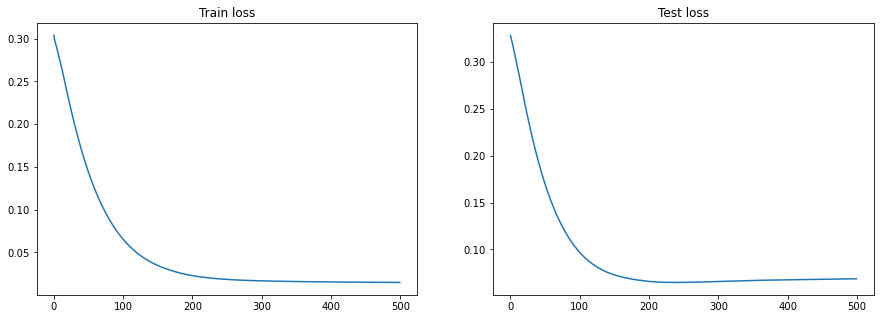

In [27]:
# Loss vs Epoch
plot_history(history)

## 1D convolutional autoencoder
(Kernel size = 3)

In [28]:
# main “event” very well represented while the overall reconstruction is very smooth 

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims
encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='tanh')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='linear', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
history = autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = autoencoder.predict(test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 650, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 650, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 325, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 325, 1)            49        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 163, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 163, 1)            4         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 326, 1)            0   

1/1 [==============================] - 0s 139ms/step - loss: 0.0339 - val_loss: 0.0534
Epoch 67/500
1/1 [==============================] - 0s 131ms/step - loss: 0.0336 - val_loss: 0.0533
Epoch 68/500
1/1 [==============================] - 0s 135ms/step - loss: 0.0334 - val_loss: 0.0532
Epoch 69/500
1/1 [==============================] - 0s 186ms/step - loss: 0.0333 - val_loss: 0.0533
Epoch 70/500
1/1 [==============================] - 0s 122ms/step - loss: 0.0332 - val_loss: 0.0533
Epoch 71/500
1/1 [==============================] - 0s 121ms/step - loss: 0.0332 - val_loss: 0.0534
Epoch 72/500
1/1 [==============================] - 0s 118ms/step - loss: 0.0332 - val_loss: 0.0535
Epoch 73/500
1/1 [==============================] - 0s 125ms/step - loss: 0.0332 - val_loss: 0.0536
Epoch 74/500
1/1 [==============================] - 0s 116ms/step - loss: 0.0333 - val_loss: 0.0537
Epoch 75/500
1/1 [==============================] - 0s 138ms/step - loss: 0.0333 - val_loss: 0.0538
Epoch 76/500


1/1 [==============================] - 0s 139ms/step - loss: 0.0326 - val_loss: 0.0524
Epoch 148/500
1/1 [==============================] - 0s 137ms/step - loss: 0.0326 - val_loss: 0.0524
Epoch 149/500
1/1 [==============================] - 0s 174ms/step - loss: 0.0326 - val_loss: 0.0524
Epoch 150/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0325 - val_loss: 0.0524
Epoch 151/500
1/1 [==============================] - 0s 129ms/step - loss: 0.0325 - val_loss: 0.0524
Epoch 152/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0325 - val_loss: 0.0524
Epoch 153/500
1/1 [==============================] - 0s 134ms/step - loss: 0.0325 - val_loss: 0.0524
Epoch 154/500
1/1 [==============================] - 0s 140ms/step - loss: 0.0325 - val_loss: 0.0523
Epoch 155/500
1/1 [==============================] - 0s 135ms/step - loss: 0.0325 - val_loss: 0.0523
Epoch 156/500
1/1 [==============================] - 0s 129ms/step - loss: 0.0325 - val_loss: 0.0523
Epoc

1/1 [==============================] - 0s 144ms/step - loss: 0.0311 - val_loss: 0.0504
Epoch 229/500
1/1 [==============================] - 0s 158ms/step - loss: 0.0311 - val_loss: 0.0504
Epoch 230/500
1/1 [==============================] - 0s 144ms/step - loss: 0.0311 - val_loss: 0.0503
Epoch 231/500
1/1 [==============================] - 0s 129ms/step - loss: 0.0311 - val_loss: 0.0503
Epoch 232/500
1/1 [==============================] - 0s 134ms/step - loss: 0.0310 - val_loss: 0.0503
Epoch 233/500
1/1 [==============================] - 0s 141ms/step - loss: 0.0310 - val_loss: 0.0502
Epoch 234/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0310 - val_loss: 0.0502
Epoch 235/500
1/1 [==============================] - 0s 143ms/step - loss: 0.0310 - val_loss: 0.0501
Epoch 236/500
1/1 [==============================] - 0s 135ms/step - loss: 0.0309 - val_loss: 0.0501
Epoch 237/500
1/1 [==============================] - 0s 143ms/step - loss: 0.0309 - val_loss: 0.0500
Epoc

1/1 [==============================] - 0s 145ms/step - loss: 0.0280 - val_loss: 0.0460
Epoch 310/500
1/1 [==============================] - 0s 146ms/step - loss: 0.0279 - val_loss: 0.0460
Epoch 311/500
1/1 [==============================] - 0s 149ms/step - loss: 0.0279 - val_loss: 0.0459
Epoch 312/500
1/1 [==============================] - 0s 135ms/step - loss: 0.0278 - val_loss: 0.0459
Epoch 313/500
1/1 [==============================] - 0s 142ms/step - loss: 0.0278 - val_loss: 0.0458
Epoch 314/500
1/1 [==============================] - 0s 149ms/step - loss: 0.0278 - val_loss: 0.0458
Epoch 315/500
1/1 [==============================] - 0s 160ms/step - loss: 0.0277 - val_loss: 0.0457
Epoch 316/500
1/1 [==============================] - 0s 154ms/step - loss: 0.0277 - val_loss: 0.0457
Epoch 317/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0277 - val_loss: 0.0457
Epoch 318/500
1/1 [==============================] - 0s 147ms/step - loss: 0.0276 - val_loss: 0.0456
Epoc

1/1 [==============================] - 0s 136ms/step - loss: 0.0267 - val_loss: 0.0443
Epoch 391/500
1/1 [==============================] - 0s 130ms/step - loss: 0.0267 - val_loss: 0.0443
Epoch 392/500
1/1 [==============================] - 0s 131ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 393/500
1/1 [==============================] - 0s 140ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 394/500
1/1 [==============================] - 0s 125ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 395/500
1/1 [==============================] - 0s 118ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 396/500
1/1 [==============================] - 0s 154ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 397/500
1/1 [==============================] - 0s 139ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 398/500
1/1 [==============================] - 0s 141ms/step - loss: 0.0267 - val_loss: 0.0442
Epoch 399/500
1/1 [==============================] - 0s 185ms/step - loss: 0.0266 - val_loss: 0.0442
Epoc

1/1 [==============================] - 0s 159ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 472/500
1/1 [==============================] - 0s 162ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 473/500
1/1 [==============================] - 0s 169ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 474/500
1/1 [==============================] - 0s 139ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 475/500
1/1 [==============================] - 0s 154ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 476/500
1/1 [==============================] - 0s 139ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 477/500
1/1 [==============================] - 0s 147ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 478/500
1/1 [==============================] - 0s 161ms/step - loss: 0.0262 - val_loss: 0.0434
Epoch 479/500
1/1 [==============================] - 0s 149ms/step - loss: 0.0262 - val_loss: 0.0433
Epoch 480/500
1/1 [==============================] - 0s 143ms/step - loss: 0.0262 - val_loss: 0.0433
Epoc

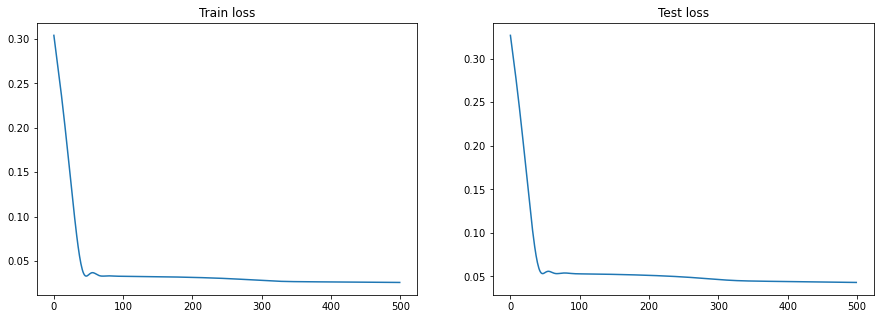

In [33]:
plot_history(history)

In [34]:
#pd.DataFrame(encoder.predict(test_set_scaled))